# Path and shape regimes of rising bubbles

## Starting point

Our goal is to predict the path and shape regime of rising bubbles depending on the Eötvös and Galilei number defined as

$$
  Ga = \frac{\sqrt{gR}R}{\nu},\quad \text{and}\quad Eo = \frac{\rho gR^2}{\sigma},
$$

with the variables being $g$ - gravitational constant, $\nu$ - kinematic liquid viscosity, $\rho$ - liquid density, and $R$ - equivalent sphere radius. The Galilei number relates interia, buoyancy, and viscous forces. The Eötvös number relates buoyancy and surface tension forces. The path and shape regimes encountered in the range $Ga\in \left[0, 800\right]$ and $Eo\in \left[0,500\right]$ are:

1. axis-symmetric shape, straight rise
2. asymmetric shape, non-oscillatory rise
3. asymmetric shape, oscillatory rise
4. peripheral breakup
5. central breakup

**Why would we want such a classifier?**

Consider the follwoing scenarios:

* The goal is to design a multiphase reactor. The reactor ought to operate in a homgeneous regime. For a given liquid, you want to have an estimate how large the bubbles sparged into the reactor can be to rise on a non-oscillatory path. Of course, the size could be determined graphically from a plot, but if the process is to be automated (e.g., in a software), a functional relationship between size and regime is required.
* In a real bubble column reactor, bubbles in all kinds of regimes will occur. In a scale-reduced simulation of such a reactor, closure models have to be defined, e.g. the drag coefficient in an Euler-Lagrange solver. The standard approach would be to use simple correlations by *Schiller and Naumann* (particles) or by *Tomiyama* (bubbles). Presumably, the correlations will be used far outside their actual range of validity, but actually there are many more correlations available for smaller sub-regimes. The classifier can be used to build a unified correlation covering a much wider parameter range with higher accuracy by automatically switching between different suitable correlations.

The following data was extracted from figure 1 in [Tripathi et al.](https://www.nature.com/articles/ncomms7268)
> Tripathi, M. K. et al. Dynamics of an initially spherical bubble rising in quiescent liquid. Nat. Commun. 6:6268 doi: 10.1038/ncomms7268 (2015)

In general, it would be sensible to gather data form as many sources as possible. The data could also be contradictory, e.g., close to decision boundaries. Most classification algorithms are robust enough to handle such data by drawing decision boundaries accroding to the *majority*.

In [1]:
# load and process .csv files
import pandas as pd
# python arrays
import numpy as np
# plotting
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
# machine learning
from sklearn import preprocessing
import torch
from torch import nn, optim
import torch.nn.functional as F
# show installed package versions
from qutip.ipynbtools import version_table

%matplotlib inline
version_table()

Software,Version
QuTiP,4.3.1
Numpy,1.16.2
SciPy,0.19.1
matplotlib,2.2.2
Cython,0.26.1
Number of CPUs,4
BLAS Info,OPENBLAS
IPython,7.4.0
Python,"3.6.8 |Anaconda custom (64-bit)| (default, Dec 30 2018, 01:22:34) [GCC 7.3.0]"
OS,posix [linux]


In [2]:
data_path = "../data/path_shape_regimes/"
regimes = ["I", "II", "III", "IV", "V"]
raw_data_files = ["regime_{}.csv".format(regime) for regime in regimes]
files = [pd.read_csv(data_path + file, header=0, names=["Ga", "Eo"]) for file in raw_data_files]
for file, regime in zip(files, regimes):
    file["regime"] = regime
data = pd.concat(files, ignore_index=True)
print("Read {} data points".format(data.shape[0]))
data.sample(5)

Read 103 data points


,Ga,Eo,regime
96,352.210,4.95910,V
34,71.178,0.49795,II
60,31.656,192.94000,IV
12,22.410,0.99230,I
33,71.102,0.10297,II


In [3]:
data.describe()

,Ga,Eo
count,103.000000,103.000000
mean,122.638672,37.759512
std,149.717655,58.145646
min,6.939000,0.099640
25%,22.600500,1.000500
50%,60.116000,10.046000
75%,186.545000,48.188500
max,518.290000,212.910000


 ## Data visualization
 
 To obtain clear stability regions as in figure 1 of the article referenced above, it is advantageous to use the **logarithm** of the features $Ga$ and $Eo$.

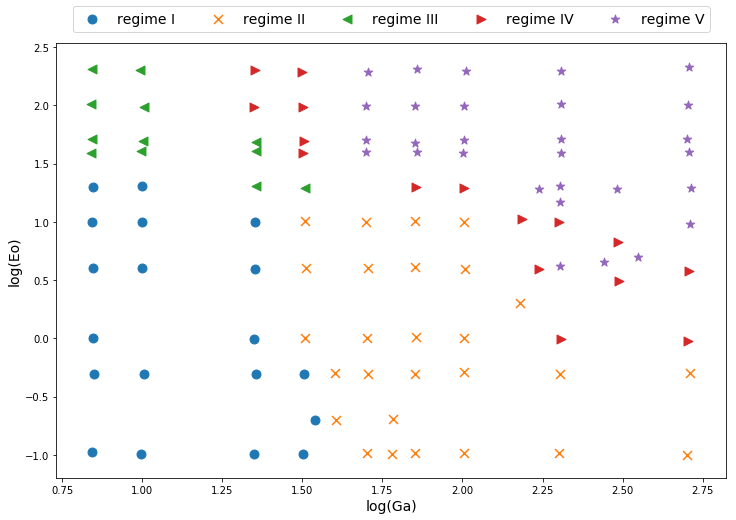

In [4]:
fontsize = 14

logData = data[["Ga", "Eo"]].apply(np.log10)
logData["regime"] = data["regime"].copy()

markers = ["o", "x", "<", ">", "*"]
plt.figure(figsize=(12, 8))
for regime, marker in zip(regimes, markers):
    plt.scatter(logData[logData["regime"] == regime].Ga, logData[logData["regime"] == regime].Eo,
                marker=marker, s=80, label="regime {}".format(regime))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=5, fontsize=fontsize)
plt.xlabel(r"log(Ga)", fontsize=fontsize)
plt.ylabel(r"log(Eo)", fontsize=fontsize)
plt.show()

## Manuel binary classification - creating a functional relationship

First, we try to write a classifier by hand. To simplify things, we focus only on regime I and II. From the plot above, the data points of region I and II look almost linearly separable. Therefore, we will define a linear function $z(Ga^\prime, Eo^\prime) = w_1Ga^\prime + w_2Eo^\prime + b$ with the transformed features $Ga^\prime = log(Ga)$ and $Eo^\prime = log(Eo)$ and build a classifier that distingishes the cases

$$
\hat{y}(z (Ga^\prime, Eo^\prime)) = \left\{\begin{array}{lr}
    0, & \text{if } \varphi \leq 0\\
    1, & \text{if } \varphi \gt 0
    \end{array}\right.
$$

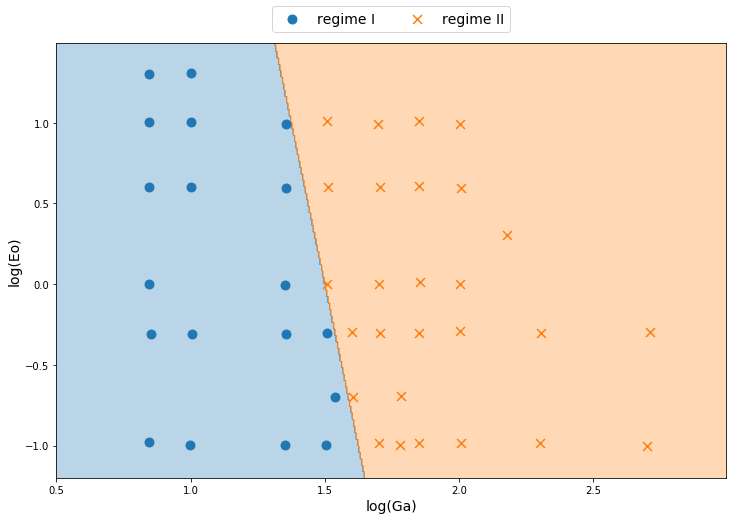

In [5]:
# resolution for plotting region contours
resolution = 0.005

def z_func(logGa, logEo):
    w1 = 8.0; w2 = 1; b = -12
    return w1 * logGa + w2 * logEo + b


def y_hat(logGa, logEo):
    return np.heaviside(z_func(logGa, logEo), 0.0)
    
    
plt.figure(figsize=(12, 8))

# color predicted region I and II
xx, yy = np.meshgrid(np.arange(0.5, 3.0, resolution), np.arange(-1.2, 1.5, resolution))
prediction = y_hat(xx.ravel(), yy.ravel())
plt.contourf(xx, yy, prediction.reshape(xx.shape), cmap=ListedColormap(['C0', 'C1']), alpha=0.3)

# plot data point for region I and II
for regime, marker in zip(regimes[:2], markers[:2]):
    plt.scatter(logData[logData["regime"] == regime].Ga, logData[logData["regime"] == regime].Eo,
                marker=marker, s=80, label="regime {}".format(regime))


plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=5, fontsize=fontsize)
plt.xlabel(r"log(Ga)", fontsize=fontsize)
plt.ylabel(r"log(Eo)", fontsize=fontsize)
plt.show()

The classifier predicts points of region I and II in the data set correctly. But there is some space for improvement:
* we had to figure out the functional relationship for $\hat{y}$ manually
* the decision boundary does not look always ideal; since we have no knowledge of the true decision boundary but some data points, it would be resonable to search for a boundary which maximizes the distance to the points closest to the boundary
* if we include more regimes, it will become more and more challanging if not impossible to separate the different regions
* the approach only works well for linearly separable data

## Using gradient descent to find the parameters/weights

In the previous section, we manually searched for the slope and offset of a linear function to separate the two classes. This process can be automated by defining and solving an optimization problem. One option would be to define a loss function which expresses the prediction quality. The true label $C$ is known for all points $i$ in the data set. The value of $y$ is $0$ for region I and $1$ for region II. The predicted label $\hat{y}$ depends on $\phi$ and therefore on the weights $w = \left[w_1, w_2, b\right]$. A common loss is the squared difference of true and predicted label $(y-\hat{y})^2$ for all $N$ data points:

$$
  L(w) = \frac{1}{2}\sum\limits_{i=1}^N \left(y_i - \hat{y}_i(w) \right)^2
$$

The prefactor $1/2$ is only for convenience, as will become clear later on. The knobs we can turn to minimize the loss are the weights $w$. The most common algorithm to find suitable weights in machine learning is gradient descent. The idea is to compute the gradient of the loss function w.r.t. the weights and then to change the weights in small steps in negative gradient direction. The gradient of $L$ is

$$
  \frac{\partial L}{\partial w_j} =
  \begin{pmatrix}\frac{\partial L}{\partial w_1}\\
                 \frac{\partial L}{\partial w_2}\\
                 \frac{\partial L}{\partial b}
  \end{pmatrix}=
  -\frac{1}{2}\sum\limits_{i=1}^N 2\left(y_i - \hat{y}_i(w) \right) \frac{\partial \hat{y}_i(w)}{\partial w_j} =
  -\sum\limits_{i=1}^N \left(y_i - \hat{y}_i \right) \delta 
  \begin{pmatrix}Ga^\prime_i\\
                 Eo^\prime_i\\
                 1
  \end{pmatrix},
$$

with the partial derivate of $\hat{y}_i(w)$ being

$$
  \frac{\partial \hat{y}_i(w)}{\partial y_j} = \delta
  \begin{pmatrix}\frac{\partial}{\partial w_1} \left(w_1Ga^\prime_i + w_2Eo^\prime_i + b\right)\\
                 \frac{\partial}{\partial w_2} \left(w_1Ga^\prime_i + w_2Eo^\prime_i + b\right)\\
                 \frac{\partial}{\partial b} \left(w_1Ga^\prime_i + w_2Eo^\prime_i + b\right)
  \end{pmatrix} = \delta
  \begin{pmatrix}Ga^\prime_i\\
                 Eo^\prime_i\\
                 1
  \end{pmatrix}.
$$

The derivative of the [Heaviside step function](https://en.wikipedia.org/wiki/Heaviside_step_function), used in the classifier, is the [Dirac distribution](https://en.wikipedia.org/wiki/Dirac_delta_function), which simply evaluates to one in each point $i$ in the equations above. To update the weights, we change the weights in negative gradient direction by a small fraction of the gradient. The learning rate $\eta$ determines how small or large the weight updates will be. The formula to update the weights is

$$
  w^{n+1} = w^n - \frac{\partial L(w)}{\partial w} =
  \begin{pmatrix}w_1^n\\
                 w_2^n\\
                 b^n
  \end{pmatrix} +
  \sum\limits_{i=1}^N \left(y_i - \hat{y}_i(w^n) \right)
  \begin{pmatrix}Ga^\prime_i\\
                 Eo^\prime_i\\
                 1
  \end{pmatrix}
$$

In [6]:
class SimpleClassifier():
    def __init__(self, eta=0.01, epochs=1000):
        self.eta_ = eta
        self.epochs_ = epochs
        self.weights_ = np.random.rand(3)
        self.loss_ = []

    def train(self, X, y):
        for e in range(self.epochs_):
            self.weights_ += self.eta_ * self.lossGradient(X, y)
            self.loss_.append(self.loss(X, y))
            if self.loss_[-1] < 1.0E-6:
                print("Training converged after {} epochs.".format(e))
                break
    
    def loss(self, X, y):
        return 0.5 * np.sum(np.square(y - self.predict(X)))
    
    def lossGradient(self, X, y):
        return np.concatenate((X, np.ones((X.shape[0], 1))), axis=1).T.dot(y - self.predict(X))
    
    def predict(self, X):
        return np.heaviside(np.dot(np.concatenate((X, np.ones((X.shape[0], 1))), axis=1), self.weights_), 0.0)

In [7]:


reducedData = logData[(logData.regime == "I") | (logData.regime == "II")]
# The LabelBinarizer converts the labels "I" and "II" to 0 and 1
lb = preprocessing.LabelBinarizer()
lb.fit(reducedData.regime)
y = lb.transform(reducedData.regime).ravel()
X = reducedData[["Ga", "Eo"]].values

classifier = SimpleClassifier()
classifier.train(X, y)
print("Computed weights: w1={:.4f}, w2={:.4f}, b={:.4f}".format(classifier.weights_[0], classifier.weights_[1], classifier.weights_[2]))

Training converged after 407 epochs.
Computed weights: w1=0.7899, w2=0.0684, b=-1.1700


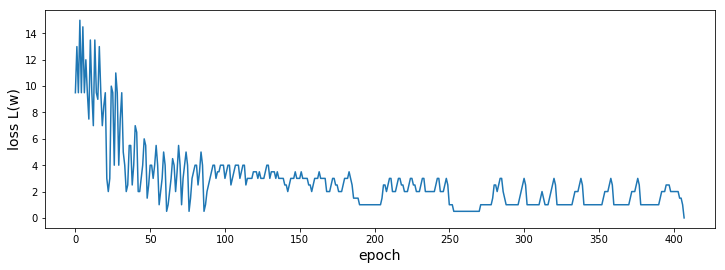

In [8]:
# plot loss over epochs
plt.figure(figsize=(12, 4))
plt.plot(range(len(classifier.loss_)), classifier.loss_)
plt.xlabel(r"epoch", fontsize=fontsize)
plt.ylabel(r"loss L(w)", fontsize=fontsize)
plt.show()

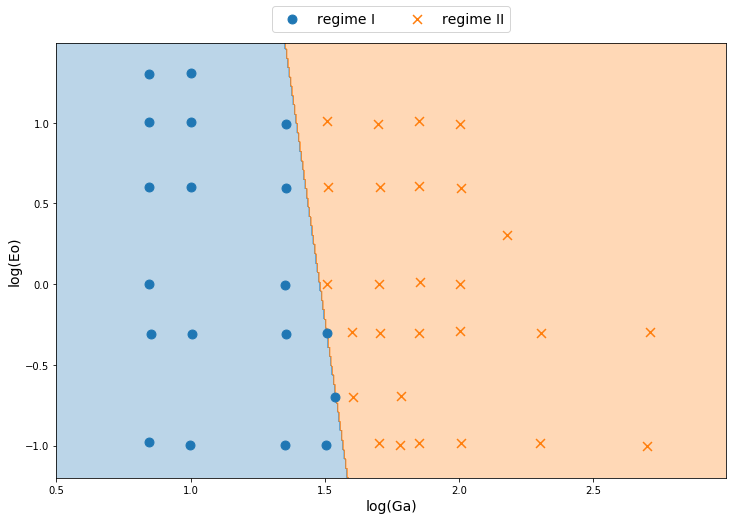

In [9]:
plt.figure(figsize=(12, 8))
prediction = classifier.predict(np.vstack((xx.ravel(), yy.ravel())).T)
plt.contourf(xx, yy, prediction.reshape(xx.shape), cmap=ListedColormap(['C0', 'C1']), alpha=0.3)
for regime, marker in zip(regimes[:2], markers[:2]):
    plt.scatter(reducedData[reducedData["regime"] == regime].Ga, reducedData[reducedData["regime"] == regime].Eo,
                marker=marker, s=80, label="regime {}".format(regime))
    
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=5, fontsize=fontsize)
plt.xlabel(r"log(Ga)", fontsize=fontsize)
plt.ylabel(r"log(Eo)", fontsize=fontsize)
plt.show()

Gradient descent is the standard algorithm in machine learning to determine parameters, e.g., of neural networks. The trained classifier learned to predict all points in the training set correctly. However, the result is still not satisfying in that
* some points are very close to the decision boundary,
* the loss does not decrease monotoneously because the loss function is not continuous (this cloud lead to convergence problems), and
* the algorithm will certainly fail to converge if the data is non linearly separable.

## Using conditional probabilities instead of binary classes

To overcome the convergence issues we need a continuous loss function. The main idea is to consider the odds for a point in the feature space to belong to a certains class instead of making a unique prediction. Before, we used the Heaviside function with $0$ corresponding to region I and $1$ corresponding to region II. Instead we could consider the probability $p$ for a point to be in region II. Probabilities can have values between zero and one. In the special case of binary classification, the probabilities of both classes together add up to one. For example, a point very far in the orange region in the figure above should have a probability close one. In contrast, a point very far in the blue region should have a probability close to zero to be organge. A point very close to the decicion boundary should have a probability around $0.5$. Note that the probability for a point to be in region I is the same as for not being in region II.

Before we used the weighted sum of our features, $z$, to describe how far a point is in region I or II. A negative $z$ led to a point being classified as region I, while a positive $z$ corresponded to region II. Now we have to find a way to convert $z$ into probabilities. There are two requirements which such a transformation function should fulfill:

1. it should map any argument to a positive real number because probabilities are always positive
2. the positive real number should be in the range $0...1$

These requirements are met by the sigmoid function $\sigma (z) = \frac{1}{1+e^{-z}}$.

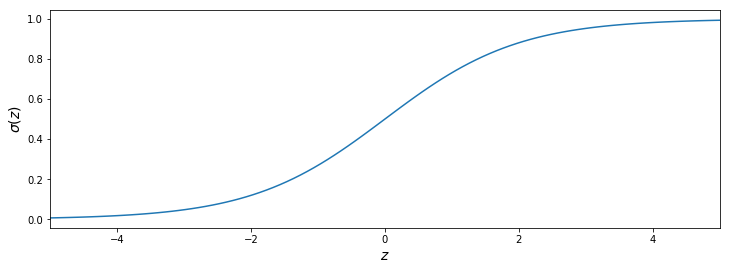

In [10]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

plt.figure(figsize=(12, 4))
plt.plot(np.linspace(-5, 5, 100), sigmoid(np.linspace(-5, 5, 100)))
plt.xlim([-5, 5])
plt.xlabel(r"$z$", fontsize=fontsize)
plt.ylabel(r"$\sigma (z)$", fontsize=fontsize)
plt.show()

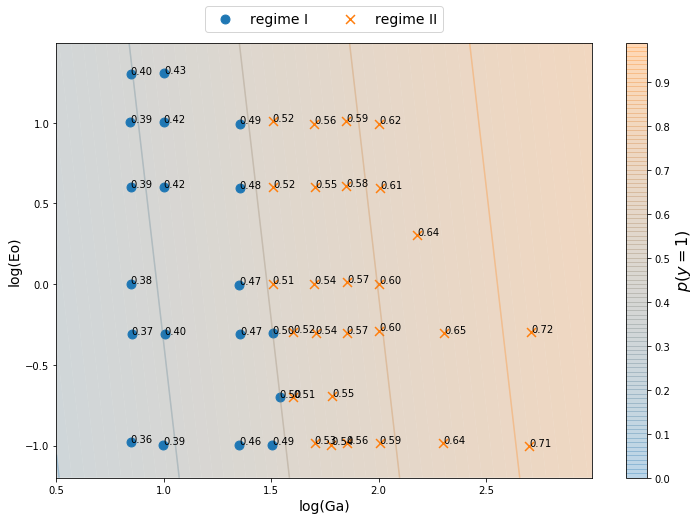

In [11]:
from matplotlib.colors import LinearSegmentedColormap

def probability(X, w):
    z = np.dot(np.concatenate((X, np.ones((X.shape[0], 1))), axis=1), w)
    return 1.0 / (1.0 + np.exp(-z))

plt.figure(figsize=(12, 8))
colors = ['C0', 'C1']
cm = LinearSegmentedColormap.from_list("blue_to_orange", colors, 100)
prediction = probability(np.vstack((xx.ravel(), yy.ravel())).T, classifier.weights_)
plt.contour(xx, yy, prediction.reshape(xx.shape),levels=[np.arange(0, 1.01, 0.1)], cmap=cm, alpha=0.3, antialiased=True)
plt.contourf(xx, yy, prediction.reshape(xx.shape),levels=np.arange(0, 1.0, 0.01), cmap=cm, alpha=0.3, antialiased=True)
plt.colorbar().set_label(r"$p(y=1)$", fontsize=16)

for regime, marker in zip(regimes[:2], markers[:2]):
    Xr = reducedData[reducedData["regime"] == regime][["Ga", "Eo"]].values
    point_prob = probability(Xr, classifier.weights_)
    for i, p in enumerate(Xr):
        plt.annotate("{:.2f}".format(point_prob[i]), (p[0], p[1]))
    plt.scatter(reducedData[reducedData["regime"] == regime].Ga, reducedData[reducedData["regime"] == regime].Eo,
                marker=marker, s=80, label="regime {}".format(regime))
    
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=5, fontsize=fontsize)
plt.xlabel(r"log(Ga)", fontsize=fontsize)
plt.ylabel(r"log(Eo)", fontsize=fontsize)
plt.show()

## Maximum likelihood and cross entropy

So far we have got one probability for each point in the training set. The question is now how to combine these probabilities such that we obtain an algorithm to compute the weights. One intuitive approach is trying to maximize the likelihood for all points to be classified correctly. This mean for a point $x_i$ in region I we want to maximize $p(y_i=0|x_i)$ (the probability of the event $y_i$ given the feature vector $x_i$), and for points in region II we maximize $p(y_i=1 | x_i)$. Assuming that each data point is an independent event, the combined probability of all $N$ points is their product. However, multiplying thounds or millions of values between zero and one would certainly lead to numerical difficulties. Therefore, it is more useful to take the logarithm of the combined probabilities because

1. the product becomes a summation since $\mathrm{ln}(ab) = \mathrm{ln}(a) + \mathrm{ln}(b)$, and
2. it helps to turn the maximization into a minimization problem.

So how is the maximization turned into a minimization? Probabilities take values between zero and one. If the argument of the logarithm is close to one, the result will be close to zero. If the argument is close to zero, the logarithm will be a large negative number. Combining these aspects results in a special loss function called *binary cross entropy*:

$$
  L(w) = -\frac{1}{N}\sum\limits_{i=1}^N y_i \mathrm{ln}(\hat{y}_i) + (1-y_i) \mathrm{ln}(1-\hat{y}_i)
  \quad \text{with} \quad \hat{y}_i = \sigma (z(w)).
$$

Since the logarithm of a value betweem zero and one is negative, the loss is defined as the negative logrithmic probabilities. Taking the mean instead of the sum makes the loss somewhat more independent of the amount of data. High probabilities $\hat{y}_i$ will lead a small cross entropy. Therefore, minimizing the cross entropy is the same is maximizing the likelihood of all points to be classified correctly, and we can use this minimization problem as a criteron to adjust the model's weights $w$ using gradient decent.

Since our classifier function $\hat{y}$ is still rather simple, we can compute the loss gradient by hand:

$$
  \frac{\partial L(w)}{\partial w_j} = -\frac{1}{N}\sum\limits_{i=1}^N
  \frac{y_i}{\hat{y}_i} \frac{\partial \hat{y}_i}{\partial w_j}
  + \frac{1-y_i}{1-\hat{y}_i} \left( -\frac{\partial \hat{y}_i}{\partial w_j} \right)
$$

with the partial derivative of the classifier w.r.t. weigths being

$$
  \frac{\partial\hat{y}_i}{\partial w_j} = \frac{\partial \sigma}{\partial z_i} \frac{\partial z_i}{\partial w_j} =
  \sigma (z_i) (1-\sigma (z_i))
  \begin{pmatrix}Ga^\prime_i\\
                 Eo^\prime_i\\
                 1
  \end{pmatrix} = 
  \hat{y}_i (1-\hat{y}_i)
  \begin{pmatrix}Ga^\prime_i\\
                 Eo^\prime_i\\
                 1
  \end{pmatrix}.
$$

Combining the above equations results in

$$
  \frac{\partial L}{\partial w_j} = -\frac{1}{N}\sum\limits_{i=1}^N (y_i - \hat{y}_i)
  \begin{pmatrix}Ga^\prime_i\\
                 Eo^\prime_i\\
                 1
  \end{pmatrix}.
$$

Some hints if you want to understand the computation in all details:

$$
  \frac{\mathrm{d}}{\mathrm{d}x}\mathrm{ln}(x) = \frac{1}{x},\quad
  \frac{\mathrm{d}}{\mathrm{d}x}\sigma(x) = \sigma (x)(1-\sigma (x)),\quad
  \frac{\mathrm{d} f(g(x))}{\mathrm{d} x} = \frac{\mathrm{d}f}{\mathrm{d}g}\frac{\mathrm{d}g}{\mathrm{d}x}
$$

Now we are ready to implement our improved classifier.

In [12]:
class LogClassifier():
    def __init__(self, eta=1.0, epochs=10000):
        self.eta_ = eta
        self.epochs_ = epochs
        self.weights_ = np.random.rand(3)
        self.loss_ = []

    def train(self, X, y, tol):
        for e in range(self.epochs_):
            self.weights_ += self.eta_ * self.lossGradient(X, y)
            self.loss_.append(self.loss(X, y))
            if self.loss_[-1] < tol:
                print("Training converged after {} epochs.".format(e))
                break
    
    def loss(self, X, y):
        logProb = y * np.log(self.probability(X)) + (1.0 - y) * np.log(1.0 - self.probability(X))
        return - np.mean(logProb)
    
    def lossGradient(self, X, y):
        return np.concatenate((X, np.ones((X.shape[0], 1))), axis=1).T.dot(y - self.probability(X)) / X.shape[0]
    
    def probability(self, X):
        z = np.dot(np.concatenate((X, np.ones((X.shape[0], 1))), axis=1), self.weights_)
        return 1.0 / (1.0 + np.exp(-z))
    
    def predict(self, X):
        return np.heaviside(self.probability(X) - 0.5, 0.0)

In [13]:
classifier = LogClassifier()
classifier.train(X, y, 0.1)
print("Computed weights: w1={:.4f}, w2={:.4f}, b={:.4f}".format(classifier.weights_[0], classifier.weights_[1], classifier.weights_[2]))

Training converged after 3020 epochs.
Computed weights: w1=14.3553, w2=1.3521, b=-21.3920


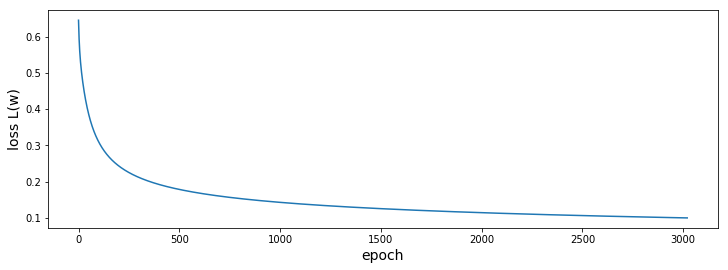

In [14]:
# plot loss over epochs
plt.figure(figsize=(12, 4))
plt.plot(range(len(classifier.loss_)), classifier.loss_)
plt.xlabel(r"epoch", fontsize=fontsize)
plt.ylabel(r"loss L(w)", fontsize=fontsize)
plt.show()

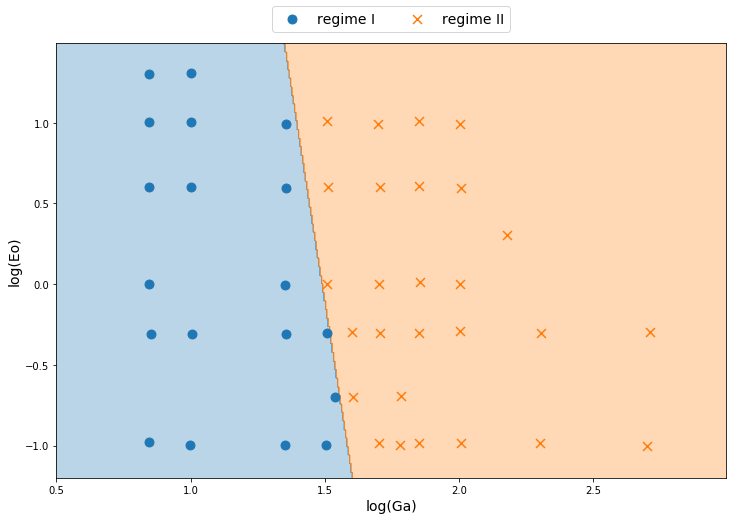

In [15]:
plt.figure(figsize=(12, 8))
prediction = classifier.predict(np.vstack((xx.ravel(), yy.ravel())).T)
plt.contourf(xx, yy, prediction.reshape(xx.shape), cmap=ListedColormap(['C0', 'C1']), alpha=0.3)
for regime, marker in zip(regimes[:2], markers[:2]):
    plt.scatter(reducedData[reducedData["regime"] == regime].Ga, reducedData[reducedData["regime"] == regime].Eo,
                marker=marker, s=80, label="regime {}".format(regime))
    
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=5, fontsize=fontsize)
plt.xlabel(r"log(Ga)", fontsize=fontsize)
plt.ylabel(r"log(Eo)", fontsize=fontsize)
plt.show()

Great, it works! What you may have observed:

- the loss decreases now monotoneously
- the decicion boundary looks slightly better in the sense that some of the points very close to it are a bit farther away now
- the algorithm would also converge if the data was not linearly separable
- we needed more iterations to get to the final weights because the loss gradient decreases with $y-\hat{y}$ as the probabilistic prediction improves

## Non-linear decicion boundaries

Now we will look at some more complex case. Region I has two neighbouring regions, namely region II and III. The goal is to separate region I from the other two region, so it is still a binary classification problem. However, a straight line will not work this time to isolate region I. If you look again at the first plot with all data points of all regions, you may notice that we could draw two lines to solve the problem: the first one will separate region I from region two, and the second one will separate region I from region III. So let's do that first.

In [16]:
# reduced data sets
data_I_II = logData[(logData.regime == "I") | (logData.regime == "II")]
data_I_III = logData[(logData.regime == "I") | (logData.regime == "III")]

# The LabelBinarizer converts the labels "I" and "II" to 0 and 1
lb_I_II = preprocessing.LabelBinarizer()
lb_I_III = preprocessing.LabelBinarizer()
lb_I_II.fit(data_I_II.regime)
lb_I_III.fit(data_I_III.regime)

# labels and features
y_I_II = lb_I_II.transform(data_I_II.regime).ravel()
y_I_III = lb_I_III.transform(data_I_III.regime).ravel()
X_I_II = data_I_II[["Ga", "Eo"]].values
X_I_III = data_I_III[["Ga", "Eo"]].values

# classifier to separate region I and II
classifier_I_II = LogClassifier()
classifier_I_II.train(X_I_II, y_I_II, tol=0.1)
print("Computed weights: w1={:.4f}, w2={:.4f}, b={:.4f}".format(
    classifier_I_II.weights_[0], classifier_I_II.weights_[1], classifier_I_II.weights_[2]))

# classifier to separate region I and III
classifier_I_III = LogClassifier()
classifier_I_III.train(X_I_III, y_I_III, tol=0.05)
print("Computed weights: w1={:.4f}, w2={:.4f}, b={:.4f}".format(
    classifier_I_III.weights_[0], classifier_I_III.weights_[1], classifier_I_III.weights_[2]))

Training converged after 3029 epochs.
Computed weights: w1=14.3544, w2=1.3521, b=-21.3906
Training converged after 3243 epochs.
Computed weights: w1=5.0923, w2=10.7122, b=-19.6183


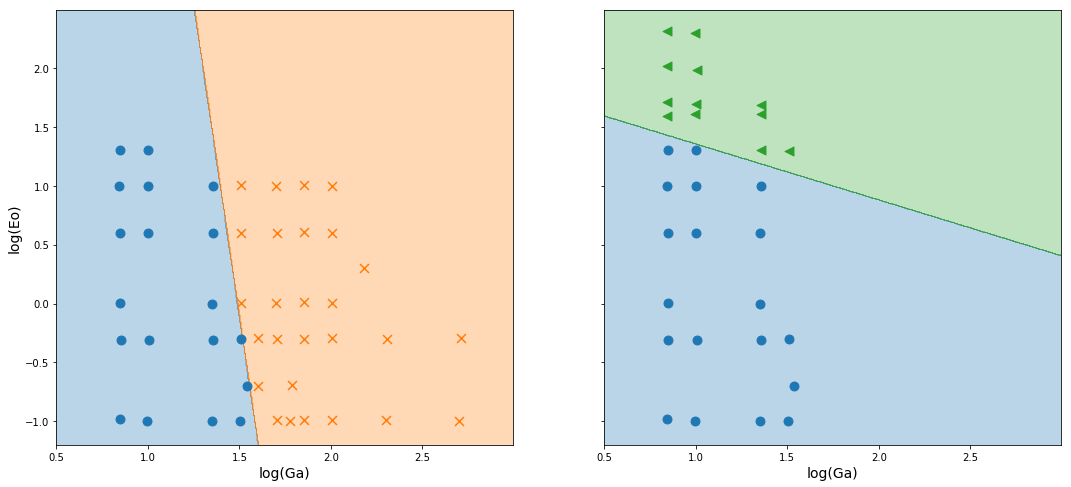

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(18, 8))
xxl, yyl = np.meshgrid(np.arange(0.5, 3.0, resolution), np.arange(-1.2, 2.5, resolution))

# region I and II
prediction_I_II = classifier_I_II.predict(np.vstack((xxl.ravel(), yyl.ravel())).T)
ax1.contourf(xxl, yyl, prediction_I_II.reshape(xxl.shape), cmap=ListedColormap(["C0", "C1"]), alpha=0.3)
for regime, marker in zip(regimes[:2], markers[:2]):
    ax1.scatter(data_I_II[data_I_II["regime"] == regime].Ga, data_I_II[data_I_II["regime"] == regime].Eo,
                marker=marker, s=80, label="regime {}".format(regime))
    
# region I and III
prediction_I_III = classifier_I_III.predict(np.vstack((xxl.ravel(), yyl.ravel())).T)
ax2.contourf(xxl, yyl, prediction_I_III.reshape(xxl.shape), cmap=ListedColormap(["C0", "C2"]), alpha=0.3)
for regime, marker, color in zip(["I", "III"], ["o", "<"], ["C0", "C2"]):
    ax2.scatter(data_I_III[data_I_III["regime"] == regime].Ga, data_I_III[data_I_III["regime"] == regime].Eo,
                marker=marker, color=color, s=80, label="regime {}".format(regime))

    
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=5, fontsize=fontsize)
ax1.set_xlabel(r"log(Ga)", fontsize=fontsize)
ax2.set_xlabel(r"log(Ga)", fontsize=fontsize)
ax1.set_ylabel(r"log(Eo)", fontsize=fontsize)
plt.show()

We have two linear models which allow to isolate region I in two steps. But what if if wanted to have a single model doing a single step to solve the problem? How to combine these linear models?

Both models compute probabilities for a point to be __not__ in region one (because they are programed this way). The simpliest way to combine both models is to add their probabilities. We could also weight the linear models or substract a constant offset. Since the sum of the probabilities can becomes larger than one, we also need map them back to the range $0...1$, for example, using the sigmoid function. The new probability for a point to be in region II or III is

$$
  \hat{y}_{i,II,III} = \sigma (\hat{y}_{i,II} + \hat{y}_{i,III}) = \sigma (\sigma(z_{i,II}) + \sigma(z_{i,III}))
$$

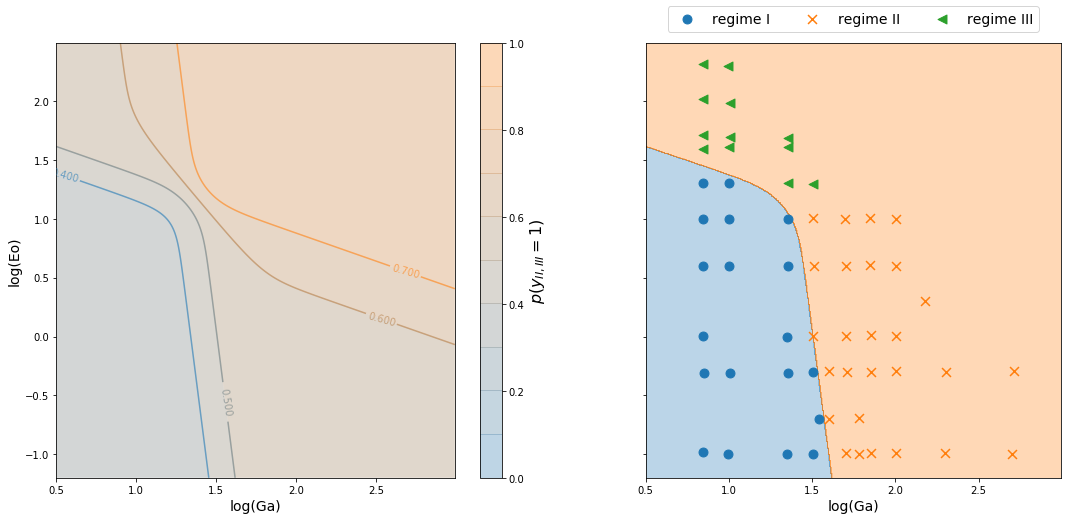

In [18]:
probability_I_II_III = sigmoid(0.9 * classifier_I_II.probability(np.vstack((xxl.ravel(), yyl.ravel())).T)
                             + 0.9 * classifier_I_III.probability(np.vstack((xxl.ravel(), yyl.ravel())).T)
                             - 0.5)
prediction_I_II_III = np.heaviside(probability_I_II_III - 0.5, 0.0)

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(18, 8), gridspec_kw={'width_ratios': [1.2, 1]})

# plot probabilities
cf1 = ax1.contourf(xxl, yyl, probability_I_II_III.reshape(xxl.shape), levels=np.arange(0.0, 1.01, 0.1), cmap=cm, alpha=0.3, antialiased=True)
c1 = ax1.contour(xxl, yyl, probability_I_II_III.reshape(xxl.shape), levels=np.arange(0.0, 1.01, 0.1), cmap=cm, alpha=0.6, antialiased=True)
ax1.clabel(c1, inline=1, fontsize=10, color='k')
fig.colorbar(cf1, ax=[ax1]).set_label(r"$p(y_{II,III}=1)$", fontsize=16)

# plot resulting decicion boundary
ax2.contourf(xxl, yyl, prediction_I_II_III.reshape(xxl.shape), cmap=ListedColormap(['C0', 'C1']), alpha=0.3)
# plot data point for region I and II in subplot 2
for regime, marker in zip(regimes[:3], markers[:3]):
    ax2.scatter(logData[logData["regime"] == regime].Ga, logData[logData["regime"] == regime].Eo,
                marker=marker, s=80, label="regime {}".format(regime))

ax1.set_xlabel(r"log(Ga)", fontsize=fontsize)
ax1.set_ylabel(r"log(Eo)", fontsize=fontsize)
ax2.set_xlabel(r"log(Ga)", fontsize=fontsize)
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=3, fontsize=fontsize)
plt.show()

The weighted combination of two linear models piped into a non-linear function (sigmoid) creates a new non-linear model with a more complex decicion boundary. If we were to draw a graphical representation of the probability function, it might look like the follwoing sketch:

In [19]:
%load_ext tikzmagic

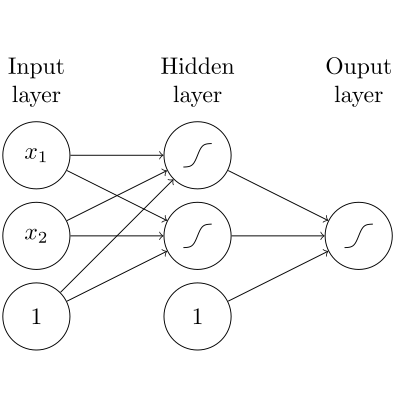

In [20]:
%%tikz -s 400,400 -sc 1.2 -f svg
\input{combined_linear_models.tikz}

## The multi-layer percepton

The function we ended up with is called **Multi-Layer-Perceptron** (MLP) or also vanilla **Neural Network**, and the motivation for this naming can be infered from the sketch above:

- the function arguments form the nodes in the *input-layer*
- the nodes in the *hidden layer* represent linear models
- the arrows connecting two nodes represent a weight (a function parameter)
- each node sums up its weighted inputs and transforms the sum using a so-called *activation function*, which is the sigmoid function in our case
- the nodes with 1 inside represent bias units (offsets of the linear functions)
- for binary classification, there is excatly one node forming the output layer, which is ultimately the proabibility $\hat{y}$

Now you could image that it is possible to combine more and more linear models in the hidden layer to form very complex decicion boundaries. Also, we could add more hidden layers and combine the output of the previous layer to get an even stronger non-linear transformation. In fact, the non-linear transformation obtained by using multiple hidden layers is one of the key-concepts for the success and popularity of neural networks. MLPs or neural networks in general with multiple hidden layers are called **Deep Neural Networks** and the weight optimization based on data sets is called **Deep Learning** (sometimes deep learning is also used as a synonym for all the technology and theory around building and training deep neural networks).

## Multi-class classification

### One-hot encoding

In the binary classification problem, we converted our *String* labels into numeric values using a binary encoding:

| original label | numeric label |
|:--------------:|:-------------:|
| I              | 0             |
| II             | 1             |

We can follow the same pattern to convert all the other classes into numeric values:

| original label | numeric label |
|:--------------:|:-------------:|
| I              | 0             |
| II             | 1             |
| III            | 2             |
| IV             | 3             |
| V              | 4             |

Considering what we learned before, there are several problems with such an encoding for multi-class classification. The model should output the probabilities for each class, thus a value between zero and one. Also, the increasing numeric label value suggests a continuous relationship between the different classes, of course, non-existent. At the latest when there are more than two neighboring regions, it becomes clear that such an encoding is not practical.

The solution to the encoding problem is to introduce new labels, one for each class (region). Instead of having one label with 5 classes, one for each region, we expand the data set to 5 labels with one class per label. This is somewhat similar to looking at the problem 5 binary classifications.

| original label | numeric label | $\rightarrow$ | is I? | is II? | is III? | is IV? | is V?|
|:--------------:|:-------------:|:-------------:|:-----:|:------:|:-------:|:------:|:----:|
| I              | 0             | $\rightarrow$ | 1     | 0      | 0       | 0      | 0    |
| II             | 1             | $\rightarrow$ | 0     | 1      | 0       | 0      | 0    |
| III            | 2             | $\rightarrow$ | 0     | 0      | 1       | 0      | 0    |
| IV             | 3             | $\rightarrow$ | 0     | 0      | 0       | 1      | 0    |
| V              | 4             | $\rightarrow$ | 0     | 0      | 0       | 0      | 1    |

This strategy is called **one-hot encoding**. In *PyTorch*, we don't have create a one-hot encoded label explicitly. The loss function implementation used later on takes numeric labels as an input and creates the encoding for us. What we have to do before, however, is to convert the region labels (*String*) into numeric labels (*int*). The *sklearn* [LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) provides exactly that functionality.

In [21]:
le = preprocessing.LabelEncoder()
y_numeric = le.fit_transform(logData.regime)
sample = logData.regime.sample(5)
for l, ln in zip(sample, le.transform(sample.values)): print("label: {:3s}, numeric label: {:1d}".format(l, ln))

label: I  , numeric label: 0
label: II , numeric label: 1
label: V  , numeric label: 4
label: IV , numeric label: 3
label: V  , numeric label: 4


### Softmax function

The generalization of the sigmoid function to multiple classes, returning a probability vector with one probability for each class, is called **softmax function**. For a class $j$ and $K$ classes, softmax is defined as

$$
  p(y_j=1 | X) = \frac{e^{z_j}}{\sum_{j=0}^{K-1} e^{z_j}}.
$$

Note that we need the softmax function only for the output layer. For the hidden layers, we can use different activation functions like *sigmoid*, *tanh*, *ReLu*, etc. In a binary classification problem, the softmax function turns back into sigmoid.

### Categorial cross entropy

As softmax is the generalization of sigmoid to multiple classes, categorial cross entropy is the multi-class extension to binary cross entropy. For each data point $i$ and class $j$, it is defined as

$$
  L(w) = -\frac{1}{N} \sum\limits_{j=0}^{K-1}\sum\limits_{i=1}^{N} y_{ij} \mathrm{ln}\left( \hat{y}_{ij} \right),
$$

where $y$ is a second order tensor with $N$ rows and $K$ columns. One entry in each row is equal to one while all other entries in that row are zero. The tensor $\hat{y}$ has the same dimensions but contains the class pobabilities for all data points. The values in each row sum up to one.

### A note on the implementation in *PyTorch*

The following *PyTroch* implementation deviates slightly from the formulas above in that a *log_softmax* function is used while the *NLLLoss* function expects log-probabilities. This distinction is a design choice to avoid the devision when evaluating the softmax function (potential underflow).

To find the network weights, we use a gradient decent algorithm enhanced with some emperical rules called [ADAM](https://arxiv.org/abs/1412.6980). The gradient is computed based on [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation) (AD). The basic idea is to employ the [chain-rule](https://en.wikipedia.org/wiki/Chain_rule) until we end up with some simple expression of which we now the exact derivative. Consider, for example, the function

$$
    f(x) = \mathrm{sin}\left( x^2 \right).
$$

This function could be written as $f(g(x)) = \mathrm{sin}\left( g(x) \right)$ with $g(x)=x^2$. Using the chain rule, we know that the generic derivative w.r.t. $x$ will be

$$
    \frac{\mathrm{d}f}{\mathrm{d}x} = \frac{\mathrm{d}f}{\mathrm{d}g}\frac{\mathrm{d}g}{\mathrm{d}x}.
$$

In an AD framework, every basic function like $\mathrm{sin}(x)$ and $x^n$ is implemented together with its derivative, here $\mathrm{cos}(x)$ and $x^{n-1}/n$. Employing the chain rule, we can compute automatically the derivative of any combination of these basic functions. In the example above we get

$$
    \frac{\mathrm{d}f}{\mathrm{d}x} = \mathrm{cos}\left( x^2 \right) 2x
$$

In [22]:
# Simple MLP built with PyTorch
class PyTorchClassifier(nn.Module):
    def __init__(self, n_features=2, n_classes=5, n_neurons=60, activation=torch.sigmoid):
        super().__init__()
        self.activation = activation
        self.layer_1 = nn.Linear(n_features, n_neurons)
        self.layer_2 = nn.Linear(n_neurons, n_neurons)
        self.layer_3 = nn.Linear(n_neurons, n_classes)
        
    def forward(self, x):
        x = self.activation(self.layer_1(x))
        x = self.activation(self.layer_2(x))
        return F.log_softmax(self.layer_3(x), dim=1)

In [46]:
regimeClassifier = PyTorchClassifier()
# categorial cross entropy taking logarithmic probabilities
criterion = nn.NLLLoss()
# stochastic gradient decent: ADAM
optimizer = optim.Adam(regimeClassifier.parameters(), lr=0.005)

In [47]:
epochs = 2000
losses = []

# convert feature and label arrays into PyTorch tensors
featureTensor = torch.from_numpy(np.float32(logData[["Ga", "Eo"]].values))
labelTensor = torch.tensor(y_numeric, dtype=torch.long)

for e in range(1, epochs):
    optimizer.zero_grad()
    # run forward pass through the network
    log_prob = regimeClassifier(featureTensor)
    # compute cross entropy
    loss = criterion(log_prob, labelTensor)
    # compute gradient of the loss function w.r.t. to the model weights
    loss.backward()
    # update weights
    optimizer.step()
    # keep track and print progress
    losses.append(loss.item())
    if e % 100 is 0:
        print("Training loss after {} epochs: {}".format(e, loss.item()))
    if losses[-1] < 3.0E-3: break

Training loss after 100 epochs: 0.4962597191333771
Training loss after 200 epochs: 0.2960616648197174
Training loss after 300 epochs: 0.21554893255233765
Training loss after 400 epochs: 0.17871230840682983
Training loss after 500 epochs: 0.15371555089950562
Training loss after 600 epochs: 0.12887978553771973
Training loss after 700 epochs: 0.10895168036222458
Training loss after 800 epochs: 0.0948609858751297
Training loss after 900 epochs: 0.08376061916351318
Training loss after 1000 epochs: 0.07233549654483795
Training loss after 1100 epochs: 0.05812164396047592
Training loss after 1200 epochs: 0.041930098086595535
Training loss after 1300 epochs: 0.026088150218129158
Training loss after 1400 epochs: 0.016919033601880074
Training loss after 1500 epochs: 0.012013190425932407
Training loss after 1600 epochs: 0.009050771594047546
Training loss after 1700 epochs: 0.00708424486219883
Training loss after 1800 epochs: 0.005693070124834776
Training loss after 1900 epochs: 0.00466626835986971

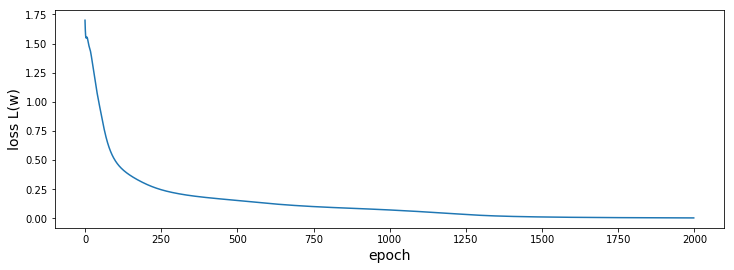

In [48]:
# plot loss over epochs
plt.figure(figsize=(12, 4))
plt.plot(range(len(losses)), losses)
plt.xlabel(r"epoch", fontsize=fontsize)
plt.ylabel(r"loss L(w)", fontsize=fontsize)
plt.show()

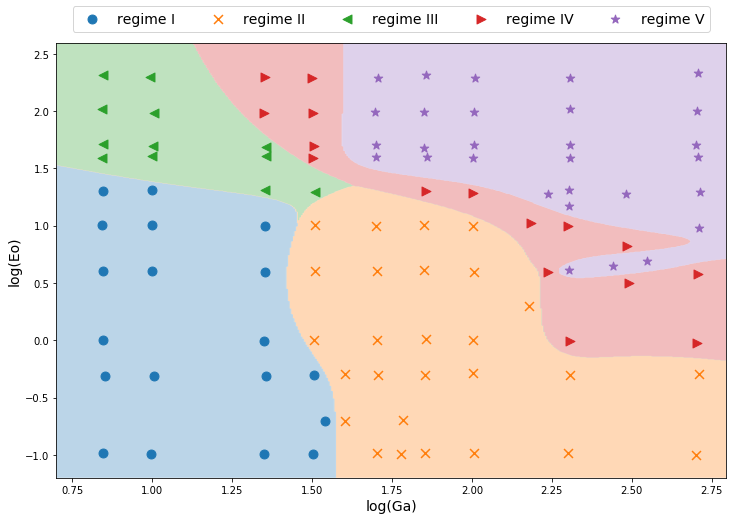

In [49]:
fig, ax = plt.subplots(figsize=(12, 8))

# color predicted regions
xxf, yyf = np.meshgrid(np.arange(0.7, 2.8, resolution), np.arange(-1.2, 2.6, resolution))
Xf = torch.from_numpy(np.float32(np.vstack((xxf.ravel(), yyf.ravel())).T))
class_prob = regimeClassifier(Xf).exp().detach().numpy()
predictionf = np.argmax(class_prob, axis=1) + 0.01 # addition of small number for plotting
cmap = ListedColormap(["C{:1d}".format(i) for i in range(5)])
ax.contourf(xxf, yyf, predictionf.reshape(xxf.shape), cmap=cmap, alpha=0.3, antialiased=True)

# plot data point for region I and II
for regime, marker in zip(regimes, markers):
    ax.scatter(logData[logData["regime"] == regime].Ga, logData[logData["regime"] == regime].Eo,
               marker=marker, s=80, label="regime {}".format(regime))

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=5, fontsize=fontsize)
ax.set_xlabel(r"log(Ga)", fontsize=fontsize)
ax.set_ylabel(r"log(Eo)", fontsize=fontsize)
plt.show()

## Final notes

The final result looks very convincing, even more than the manually drawn decicion boundaries from the original article. However, there are still some points we could improve:

- The training was stopped after the loss decreased below a certain tolerance. Depending on the chosen tolerance, also the final decicion boundary will vary. If we have many paramters and train for many epochs, the model can be over-adjusted to data (over-fitting). In that case the model will have a high accuracy on the training data, but it may not generalize very well to new data points of which do not know the label.
- A common strategy to avoid over-fitting is the split the dataset in training, validation, and validation data. Training and validation data are used to train the model and to check when it starts to over-fit (keywords: cross validation, early stopping). The test set is not used for training but only for the final evaluation.